In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import json
import random
import pickle
import os
import datetime
from Sampling import sample_graph, get_modified_at_array

In [2]:
def truncate_playlists(playlists):
    new_playlists = list()
    for playlist in playlists:
        new_playlist = list({'name': f"{i['artist_name']} - {i['track_name']}", 'track_uri': i['track_uri'][len("spotify:"):]} for i in playlist['tracks'])
        new_playlists.append(new_playlist)
        
    return new_playlists

In [3]:
#CHANGE THIS DEPENDING ON YOUR DATA LOCATION
path = "DATA/"

In [70]:
G, test_playlists = sample_graph(verbose=True, path=path, testSplit=True)

15/15; time elapsed: 0.0 min 20.1 sec
Time elapsed: 0.0 min  20.131518400000004 sec
n:326244, m:1007538; 


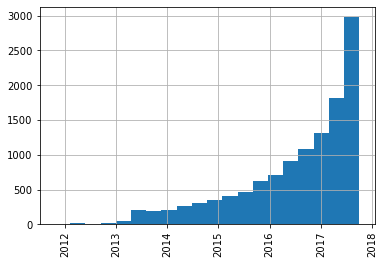

In [71]:
G_ser = get_modified_at_array(G,True)

In [72]:
len(test_playlists)

3049

In [73]:
#list({'name': f"{i['artist_name']} - {i['track_name']}", 'track_uri': i['track_uri'][len("spotify:"):]} for i in test_playlists[0]['tracks'])

In [74]:
test_playlists = truncate_playlists(test_playlists)

In [75]:
test_playlists[17]

[{'name': 'Jonas Brothers - Lovebug',
  'track_uri': 'track:3Q0Ngf7Llu1KIteVHRfiXw'},
 {'name': 'Miley Cyrus - Fly On The Wall',
  'track_uri': 'track:2f6s0AcBRBE0vIOU0NMdXw'},
 {'name': 'Jonas Brothers - S.O.S.',
  'track_uri': 'track:1ZP0sKDoVM1NCFB65Esfm6'},
 {'name': 'Ashley Tisdale - Kiss the Girl',
  'track_uri': 'track:6kkFjjMbO9EL1YxNt8BKm3'},
 {'name': 'Selena Gomez & The Scene - Love You Like A Love Song',
  'track_uri': 'track:0laYHRpNTS6i8FXdupHkJ4'},
 {'name': 'High School Musical Cast - The Boys Are Back',
  'track_uri': 'track:6YoYLN155MLavQcl3bHmvY'},
 {'name': "Jonas Brothers - Burnin' Up",
  'track_uri': 'track:7yMnml7zdYl5LlDFZPm5Hd'},
 {'name': 'Miley Cyrus - 7 Things',
  'track_uri': 'track:5ecZWU5uQOiCVSnPxBZNmT'},
 {'name': 'The Cheetah Girls - Dance Me If You Can',
  'track_uri': 'track:4Fzd0BCMixW1jqpOLiBvRe'},
 {'name': 'Jesse McCartney - Beautiful Soul',
  'track_uri': 'track:1HwpWwa6bnqqRhK8agG4RS'},
 {'name': 'Miley Cyrus - Hoedown Throwdown',
  'track_uri'

#### Random Walk method - proof of concept

In [4]:
from Algorithms import randWalkReccs

In [95]:
pd = random.sample(test_playlists[0],2)
personalization_vect = [i['track_uri'] for i in pd]

In [96]:
personalization_vect

['track:5xbrhx2tMMcN68IT3cJbhS', 'track:4bJX21zvsGJELwVNf902qk']

In [97]:
start = timeit.default_timer()
num_iterations = 100*max(len(personalization_vect),10)
walk_steps = 12
results = randWalkReccs(G, num_iterations, walk_steps, personalization=personalization_vect)
stop = timeit.default_timer()
print('Time elapsed (minutes):', (stop - start)/60)  

Time elapsed (minutes): 0.0007866933333332326


In [98]:
rec_songs = filter(lambda x: str.startswith(str(x[0]), "track:"), results.items())
reccs = sorted(rec_songs, key=lambda x: x[1], reverse=True)
len(reccs)

3339

In [99]:
predicted_playlist = [{'name': f"{G.nodes[reccs[i][0]]['artist_name']} - {G.nodes[reccs[i][0]]['track_name']}",'track_uri':reccs[i][0]} for i in range(len(test_playlists[0])-2)]

In [100]:
len(set(p['track_uri'] for p in predicted_playlist).intersection(set(p['track_uri'] for p in test_playlists[0])))/len(test_playlists[0])

0.09815950920245399

#### Actual test run

In [5]:
G, test_playlists = sample_graph(verbose=True, path=path, testSplit=True)
test_playlists = truncate_playlists(test_playlists)

15/15; time elapsed: 0.0 min 18.1 sec
Time elapsed: 0.0 min  18.092088699999998 sec
n:322433, m:997846; 


In [13]:
def evaluation_run(G,test_data,generator_function, different_starts = 1,persvec_lengths=4,walksteps=12,verbose=False):
    timer_start = timeit.default_timer()
    exceptions = 0
    global_counter = 0
    r_precisions = dict()
    
    assert min([len(i) for i in test_data]) > persvec_lengths, "This will be a problem. Some playlists are shorter than the personalization vector."
    
    for i in range(1,persvec_lengths+1):
        r_precisions[i] = list()
    
    for test_playlist in test_data:
        for persvec_length in range(1,persvec_lengths+1):
            for _ in range(different_starts):
                persvec = [track['track_uri'] for track in random.sample(test_playlist,persvec_length)]
                try:
                    res = generator_function(G, 100*max(len(persvec),10), walksteps, personalization=persvec)

                    rec_songs = filter(lambda x: str.startswith(str(x[0]), "track:"), res.items())
                    reccs = sorted(rec_songs, key=lambda x: x[1], reverse=True)

                    predicted_playlist = [reccs[i][0] for i in range(len(test_playlist)-2)]
                    
                    r_precision = len(set(predicted_playlist).intersection(set(p['track_uri'] for p in test_playlist)))/len(test_playlist)
                    r_precisions[persvec_length].append(r_precision)
                    
                    if verbose:
                        time_elapsed = timeit.default_timer() - timer_start
                        mins_elapsed = (time_elapsed)//60
                        secs_elapsed = time_elapsed % 60
                        print(f"{global_counter+exceptions+1}/{len(test_data)*persvec_lengths*different_starts}; time elapsed: {mins_elapsed:02.1f} min {secs_elapsed:02.1f} sec", end="\r")
                    
                    global_counter+=1
                except:
                    exceptions+=1
                    
    print(f"Number of exceptions (should be 0 in complete graph): {exceptions}")
    
    return r_precisions
    

In [14]:
statistics = evaluation_run(G, test_playlists, randWalkReccs, persvec_lengths=4,verbose=True)

Number of exceptions (should be 0 in complete graph): 3425


In [15]:
[{'length of PV':t,'mean': np.mean(statistics[t]),'max': max(statistics[t]), 'std': np.std(statistics[t])} for t in statistics]

[{'length of PV': 1,
  'mean': 0.11320771280968822,
  'max': 0.7272727272727273,
  'std': 0.08986470372053537},
 {'length of PV': 2,
  'mean': 0.1465774902881514,
  'max': 0.8484848484848485,
  'std': 0.0954436418211173},
 {'length of PV': 3,
  'mean': 0.17275412224746184,
  'max': 0.8484848484848485,
  'std': 0.1014452959735157},
 {'length of PV': 4,
  'mean': 0.19653167646853908,
  'max': 0.8484848484848485,
  'std': 0.10694077328345943}]

(array([582., 705., 441., 190.,  72.,  26.,  14.,   2.,   1.,   1.]),
 array([0.0209205 , 0.10367694, 0.18643337, 0.26918981, 0.35194624,
        0.43470268, 0.51745911, 0.60021554, 0.68297198, 0.76572841,
        0.84848485]),
 <a list of 10 Patch objects>)

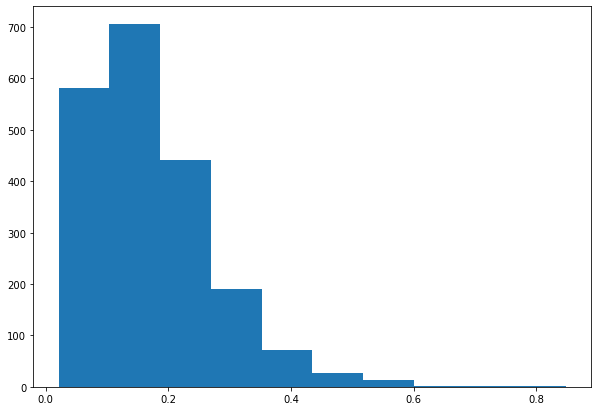

In [16]:
plt.figure(figsize=(10,7))
plt.hist(statistics[3])

(array([546., 611., 517., 374., 289., 227., 188., 116., 115.,  68.]),
 array([  5. ,  29.5,  54. ,  78.5, 103. , 127.5, 152. , 176.5, 201. ,
        225.5, 250. ]),
 <a list of 10 Patch objects>)

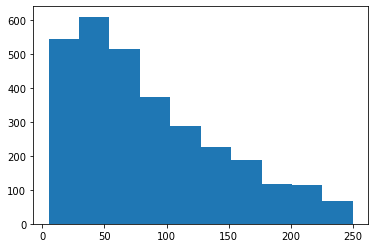

In [19]:
plt.hist([len(i) for i in test_playlists])
